<a href="https://colab.research.google.com/github/soumiyak/BDA-PROJECT/blob/main/Employee_performance_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425344 sha256=513ce993239256fdecd69c84e0ce9dcedffff3019aad4519a2da5753829da231
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [ ]:
# Import PySpark libraries
from pyspark.sql import SparkSession
from pyspark.ml.feature import Imputer
import pandas as pd

In [ ]:
spark = SparkSession.builder.appName("EmployeePerformance").getOrCreate()

# Read the Excel file into a Pandas DataFrame
excel_file_path = '/content/INX_Future_Inc_Employee_Performance_CDS_Project2_Dataset 1.xls'
pandas_df = pd.read_excel(excel_file_path)

# Convert the Pandas DataFrame into a PySpark DataFrame
df = spark.createDataFrame(pandas_df)

In [ ]:
df.show()
from pyspark.sql.functions import when

# Assuming you have a DataFrame named 'df'
df = df.withColumn("PerformanceRating", when(df["PerformanceRating"] == 4, 1).otherwise(0))
df.show()

+---------+---+------+-------------------+-------------+---------------+--------------------+-----------------------+----------------+-----------------+--------------------------+-------------+-----------------+-----------+------------------+------------------+--------+------------------------+---------------------------+--------------------------+---------------------+------------------+----------------------------+----------------------------+-----------------------+--------------------+---------+-----------------+
|EmpNumber|Age|Gender|EducationBackground|MaritalStatus|  EmpDepartment|          EmpJobRole|BusinessTravelFrequency|DistanceFromHome|EmpEducationLevel|EmpEnvironmentSatisfaction|EmpHourlyRate|EmpJobInvolvement|EmpJobLevel|EmpJobSatisfaction|NumCompaniesWorked|OverTime|EmpLastSalaryHikePercent|EmpRelationshipSatisfaction|TotalWorkExperienceInYears|TrainingTimesLastYear|EmpWorkLifeBalance|ExperienceYearsAtThisCompany|ExperienceYearsInCurrentRole|YearsSinceLastPromotion|Year

**PREPROCESSING**

In [ ]:
from pyspark.sql.functions import isnan, count,when

# Count the number of missing values in each column
missing_values_count = df.agg(*[count(when(isnan(c), 1)).alias(c) for c in df.columns])

# Display the number of missing values in each column
missing_values_count.show()


+---------+---+------+-------------------+-------------+-------------+----------+-----------------------+----------------+-----------------+--------------------------+-------------+-----------------+-----------+------------------+------------------+--------+------------------------+---------------------------+--------------------------+---------------------+------------------+----------------------------+----------------------------+-----------------------+--------------------+---------+-----------------+
|EmpNumber|Age|Gender|EducationBackground|MaritalStatus|EmpDepartment|EmpJobRole|BusinessTravelFrequency|DistanceFromHome|EmpEducationLevel|EmpEnvironmentSatisfaction|EmpHourlyRate|EmpJobInvolvement|EmpJobLevel|EmpJobSatisfaction|NumCompaniesWorked|OverTime|EmpLastSalaryHikePercent|EmpRelationshipSatisfaction|TotalWorkExperienceInYears|TrainingTimesLastYear|EmpWorkLifeBalance|ExperienceYearsAtThisCompany|ExperienceYearsInCurrentRole|YearsSinceLastPromotion|YearsWithCurrManager|Attriti

In [ ]:
#To check for missing values in a specific column
# Check for missing values in the "Age" column
missing_values_count = df.filter(isnan(df["Age"])).count()

# Print the number of missing values
print(missing_values_count)

0



Convert the categorical features to numerical features

In [ ]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline

In [ ]:
# Define categorical columns to encode
categorical_cols = ["Gender",
                    "EducationBackground",
                    "MaritalStatus",
                    "EmpDepartment",
                    "EmpJobRole",
                    "BusinessTravelFrequency",
                    "OverTime",
                    "Attrition"]

# Create a list of StringIndexer stages for categorical columns
indexers = [StringIndexer(inputCol=col, outputCol=col+"_index") for col in categorical_cols]

# Create a list of OneHotEncoder stages for indexed categorical columns
encoders = [OneHotEncoder(inputCol=col+"_index", outputCol=col+"_encoded") for col in categorical_cols]

# Create a pipeline to execute all indexers and encoders
pipeline = Pipeline(stages=indexers + encoders)

# Fit and transform the data using the pipeline
model = pipeline.fit(df)
data_encoded = model.transform(df)

# Drop the original categorical columns
data_encoded = data_encoded.drop(*categorical_cols)

# Show the resulting dataset
data_encoded.show()

+---------+---+----------------+-----------------+--------------------------+-------------+-----------------+-----------+------------------+------------------+------------------------+---------------------------+--------------------------+---------------------+------------------+----------------------------+----------------------------+-----------------------+--------------------+-----------------+------------+-------------------------+-------------------+-------------------+----------------+-----------------------------+--------------+---------------+--------------+---------------------------+---------------------+---------------------+------------------+-------------------------------+----------------+-----------------+
|EmpNumber|Age|DistanceFromHome|EmpEducationLevel|EmpEnvironmentSatisfaction|EmpHourlyRate|EmpJobInvolvement|EmpJobLevel|EmpJobSatisfaction|NumCompaniesWorked|EmpLastSalaryHikePercent|EmpRelationshipSatisfaction|TotalWorkExperienceInYears|TrainingTimesLastYear|EmpWork

MODEL TRAINING AND PREDICTION

In [ ]:
!pip install pyspark --upgrade

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [ ]:
df.select("PerformanceRating").distinct().show()

+-----------------+
|PerformanceRating|
+-----------------+
|                1|
|                0|
+-----------------+



In [ ]:


# Exclude non-numeric and irrelevant columns
feature_columns = [col for col in data_encoded.columns if col not in ["EmpNumber", "Attrition", "PerformanceRating"]]

# Create a vector assembler
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
data_assembled = assembler.transform(data_encoded)

# Split the data into training and testing sets
train_data, test_data = data_assembled.randomSplit([0.8, 0.2], seed=42)

# Define a machine learning model (Gradient-Boosted Tree Classifier)
gbt_classifier = GBTClassifier(labelCol="PerformanceRating", featuresCol="features", maxIter=10, seed=42)

# Train the model


model = gbt_classifier.fit(train_data)

# Make predictions on the test data
predictions = model.transform(test_data)

# Evaluate the model's performance
evaluator = MulticlassClassificationEvaluator(labelCol="PerformanceRating", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Accuracy: {accuracy * 100:.2f}%")




Accuracy: 97.36%


With pipeline


In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Exclude non-numeric and irrelevant columns
feature_columns = [col for col in data_encoded.columns if col not in ["EmpNumber", "Attrition", "PerformanceRating"]]

# Create a vector assembler
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# Define a machine learning model (Gradient-Boosted Tree Classifier)
gbt_classifier = GBTClassifier(labelCol="PerformanceRating", featuresCol="features", maxIter=10, seed=42)

# Create a pipeline
pipeline = Pipeline(stages=[assembler, gbt_classifier])

# Split the data into training and testing sets
train_data, test_data = data_encoded.randomSplit([0.8, 0.2], seed=42)

# Train the model using the pipeline
model = pipeline.fit(train_data)

# Make predictions on the test data
predictions = model.transform(test_data)

# Evaluate the model's performance
evaluator = MulticlassClassificationEvaluator(labelCol="PerformanceRating", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Accuracy: {accuracy * 100:.2f}%")


Accuracy: 97.36%


DT without pipeline

In [ ]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Exclude non-numeric and irrelevant columns
feature_columns = [col for col in data_encoded.columns if col not in ["EmpNumber", "Attrition", "PerformanceRating"]]

# Create a vector assembler
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
data_assembled = assembler.transform(data_encoded)

# Split the data into training and testing sets
train_data, test_data = data_assembled.randomSplit([0.8, 0.2], seed=42)

# Define a machine learning model (Decision Tree Classifier)
dt_classifier = DecisionTreeClassifier(labelCol="PerformanceRating", featuresCol="features", seed=42)  # You can adjust other hyperparameters as needed

# Train the model
model = dt_classifier.fit(train_data)

# Make predictions on the test data
predictions = model.transform(test_data)

# Evaluate the model's performance
evaluator = MulticlassClassificationEvaluator(labelCol="PerformanceRating", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Accuracy: {accuracy * 100:.2f}%")


Accuracy: 97.80%


DT WITH PIPELINE

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Exclude non-numeric and irrelevant columns
feature_columns = [col for col in data_encoded.columns if col not in ["EmpNumber", "Attrition", "PerformanceRating"]]

# Create a vector assembler
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# Define a machine learning model (Decision Tree Classifier)
dt_classifier = DecisionTreeClassifier(labelCol="PerformanceRating", featuresCol="features", seed=42)

# Create a pipeline
pipeline = Pipeline(stages=[assembler, dt_classifier])

# Split the data into training and testing sets
train_data, test_data = data_encoded.randomSplit([0.8, 0.2], seed=42)

# Train the model using the pipeline
model = pipeline.fit(train_data)

# Make predictions on the test data
predictions = model.transform(test_data)

# Evaluate the model's performance
evaluator = MulticlassClassificationEvaluator(labelCol="PerformanceRating", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Accuracy: {accuracy * 100:.2f}%")


Accuracy: 97.80%


LR without pipeline


In [ ]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Exclude non-numeric and irrelevant columns
feature_columns = [col for col in data_encoded.columns if col not in ["EmpNumber", "Attrition", "PerformanceRating"]]

# Create a vector assembler
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
data_assembled = assembler.transform(data_encoded)

# Split the data into training and testing sets
train_data, test_data = data_assembled.randomSplit([0.8, 0.2], seed=42)

# Define a machine learning model (Logistic Regression Classifier)
lr_classifier = LogisticRegression(labelCol="PerformanceRating", featuresCol="features", maxIter=10, regParam=0.01, elasticNetParam=0.8, family="multinomial", fitIntercept=True, standardization=True, predictionCol="prediction", probabilityCol="probability", rawPredictionCol="rawPrediction")

# Train the model
model = lr_classifier.fit(train_data)

# Make predictions on the test data
predictions = model.transform(test_data)

# Evaluate the model's performance
evaluator = MulticlassClassificationEvaluator(labelCol="PerformanceRating", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Accuracy: {accuracy * 100:.2f}%")


Accuracy: 92.07%


RT with pipeline

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Exclude non-numeric and irrelevant columns
feature_columns = [col for col in data_encoded.columns if col not in ["EmpNumber", "Attrition", "PerformanceRating"]]

# Create a vector assembler
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# Define a machine learning model (Logistic Regression Classifier)
lr_classifier = LogisticRegression(labelCol="PerformanceRating", featuresCol="features", maxIter=10, regParam=0.01, elasticNetParam=0.8, family="multinomial", fitIntercept=True, standardization=True, predictionCol="prediction", probabilityCol="probability", rawPredictionCol="rawPrediction")

# Create a pipeline
pipeline = Pipeline(stages=[assembler, lr_classifier])

# Split the data into training and testing sets
train_data, test_data = data_encoded.randomSplit([0.8, 0.2], seed=42)

# Train the model using the pipeline
model = pipeline.fit(train_data)

# Make predictions on the test data
predictions = model.transform(test_data)

# Evaluate the model's performance
evaluator = MulticlassClassificationEvaluator(labelCol="PerformanceRating", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Accuracy: {accuracy * 100:.2f}%")


Accuracy: 92.07%


HYPER PARAMETER TUNING:

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Exclude non-numeric and irrelevant columns
feature_columns = [col for col in data_encoded.columns if col not in ["EmpNumber", "Attrition", "PerformanceRating"]]

# Create a vector assembler
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# Define a machine learning model (Gradient-Boosted Tree Classifier)
gbt_classifier = GBTClassifier(labelCol="PerformanceRating", featuresCol="features")

# Create a pipeline
pipeline = Pipeline(stages=[assembler, gbt_classifier])

# Split the data into training and testing sets
train_data, test_data = data_encoded.randomSplit([0.8, 0.2], seed=42)

# Set up a parameter grid for hyperparameter tuning
param_grid = ParamGridBuilder() \
    .addGrid(gbt_classifier.maxDepth, [5, 10, 15]) \
    .addGrid(gbt_classifier.maxBins, [32, 64, 128]) \
    .build()

# Set up cross-validation with hyperparameter tuning
evaluator = MulticlassClassificationEvaluator(labelCol="PerformanceRating", predictionCol="prediction", metricName="accuracy")
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=param_grid,
                          evaluator=evaluator,
                          numFolds=5)

# Train the model using the pipeline with hyperparameter tuning
best_model = crossval.fit(train_data)

# Make predictions on the test data
predictions = best_model.transform(test_data)

# Evaluate the model's performance
accuracy_gbt = evaluator.evaluate(predictions)
print(f"Accuracy: {accuracy_gbt * 100:.2f}%")



Accuracy: 97.36%


DT hyperparameter:

In [ ]:

from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Exclude non-numeric and irrelevant columns
feature_columns = [col for col in data_encoded.columns if col not in ["EmpNumber", "Attrition", "PerformanceRating"]]

# Create a vector assembler
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# Define a machine learning model (Decision Tree Classifier)
dt_classifier = DecisionTreeClassifier(labelCol="PerformanceRating", featuresCol="features", seed=42)

# Create a pipeline
pipeline = Pipeline(stages=[assembler, dt_classifier])

# Split the data into training and testing sets
train_data, test_data = data_encoded.randomSplit([0.8, 0.2], seed=42)

# Set up a parameter grid for hyperparameter tuning
param_grid = ParamGridBuilder() \
    .addGrid(dt_classifier.maxDepth, [5, 10, 15]) \
    .addGrid(dt_classifier.maxBins, [32, 64, 128]) \
    .build()

# Set up cross-validation with hyperparameter tuning
evaluator = MulticlassClassificationEvaluator(labelCol="PerformanceRating", predictionCol="prediction", metricName="accuracy")
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=param_grid,
                          evaluator=evaluator,
                          numFolds=5)

# Train the model using the pipeline with hyperparameter tuning
best_model = crossval.fit(train_data)

# Make predictions on the test data
predictions = best_model.transform(test_data)

# Evaluate the model's performance
accuracy_dt = evaluator.evaluate(predictions)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Print the best hyperparameters
best_maxDepth = best_model.bestModel.stages[1].getOrDefault("maxDepth")
best_maxBins = best_model.bestModel.stages[1].getOrDefault("maxBins")
print(f"Best Max Depth: {best_maxDepth}")
print(f"Best Max Bins: {best_maxBins}")


Accuracy: 92.07%
Best Max Depth: 5
Best Max Bins: 32


In [ ]:
from pyspark.ml.classification import LogisticRegression

# Define a machine learning model (Logistic Regression)
logistic_regression = LogisticRegression(labelCol="PerformanceRating", featuresCol="features")

# Create a pipeline
pipeline_lr = Pipeline(stages=[assembler, logistic_regression])

# Split the data into training and testing sets
train_data, test_data = data_encoded.randomSplit([0.8, 0.2], seed=42)

# Set up a parameter grid for hyperparameter tuning
param_grid_lr = ParamGridBuilder() \
    .addGrid(logistic_regression.regParam, [0.01, 0.1, 1.0]) \
    .addGrid(logistic_regression.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()

# Set up cross-validation with hyperparameter tuning
evaluator_lr = MulticlassClassificationEvaluator(labelCol="PerformanceRating", predictionCol="prediction", metricName="accuracy")
crossval_lr = CrossValidator(estimator=pipeline_lr,
                            estimatorParamMaps=param_grid_lr,
                            evaluator=evaluator_lr,
                            numFolds=5)

# Train the model using the pipeline with hyperparameter tuning
best_model_lr = crossval_lr.fit(train_data)

# Make predictions on the test data
predictions_lr = best_model_lr.transform(test_data)

# Evaluate the model's performance
accuracy_lr = evaluator_lr.evaluate(predictions_lr)
print(f"Accuracy (Logistic Regression): {accuracy_lr * 100:.2f}%")

# Print the best hyperparameters
best_regParam = best_model_lr.bestModel.stages[1].getOrDefault("regParam")
best_elasticNetParam = best_model_lr.bestModel.stages[1].getOrDefault("elasticNetParam")
print(f"Best Regularization Parameter (regParam): {best_regParam}")
print(f"Best Elastic Net Parameter (elasticNetParam): {best_elasticNetParam}")


Accuracy (Logistic Regression): 92.07%
Best Regularization Parameter (regParam): 0.01
Best Elastic Net Parameter (elasticNetParam): 1.0


RT hyperparameter


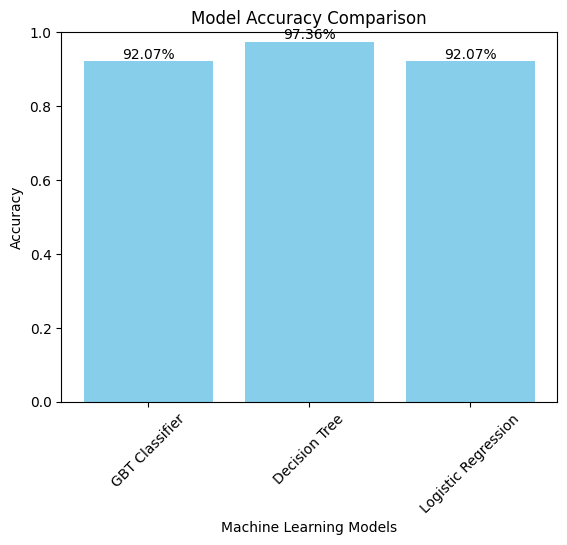

In [ ]:
import matplotlib.pyplot as plt

# List of model names and their corresponding accuracies
model_names = ["GBT Classifier", "Decision Tree", "Logistic Regression"]
accuracies = [ accuracy, accuracy_gbt,accuracy_lr]  # Replace with actual accuracy values

# Create a bar plot
plt.bar(model_names, accuracies, color='skyblue')
plt.xlabel("Machine Learning Models")
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison")
plt.ylim(0, 1)  # Set the y-axis limits (0 to 100%)
plt.xticks(rotation=45)

# Display the accuracies on top of the bars
for i, v in enumerate(accuracies):
    plt.text(i, v, f"{v*100:.2f}%", ha='center', va='bottom')

plt.show()
